# Importing Libraries

In [2]:
import os
import torch
import random
import pickle
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from copy import deepcopy
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from collections import defaultdict
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, Subset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
seed = 42 # Set a fixed seed for reproducibility
random.seed(seed) # Python's built-in random module
np.random.seed(seed) # NumPy
torch.manual_seed(seed) # PyTorch
torch.cuda.manual_seed(seed) # If using CUDA
torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# # Ensure deterministic behavior (can slow down performance)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# Loading Dataset

In [4]:
# Define transformation for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    # transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])


def load_cifar10(transform, root='./data', train=True):
    return datasets.CIFAR10(root=root, train=train, download=True, transform=transform)

def split_dataset(dataset, train_ratio=0.8): # Split dataset into training and testing subsets
    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    test_size = dataset_size - train_size

    train_indices = list(range(train_size))
    test_indices = list(range(train_size, dataset_size))

    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_dataset, test_dataset

def subset_to_numpy(dataset, subset): # Convert Subsets to numpy arrays
    images = dataset.data[subset.indices]
    labels = np.array(dataset.targets)[subset.indices]
    return images, labels

CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
cifar10_dataset = load_cifar10(transform=transform)
train_dataset, test_dataset = split_dataset(cifar10_dataset)

train_images, train_labels = subset_to_numpy(cifar10_dataset, train_dataset)
test_images, test_labels = subset_to_numpy(cifar10_dataset, test_dataset)

print(f"Dataset size: {len(cifar10_dataset)}")
print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")

# Optionally create data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [00:16<00:00, 10178163.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Dataset size: 50000
Train images shape: (40000, 32, 32, 3), Train labels shape: (40000,)
Test images shape: (10000, 32, 32, 3), Test labels shape: (10000,)


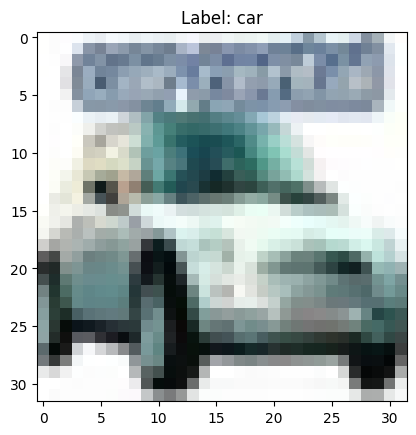

In [7]:
#display an image along with its label
idx = 0
image = test_images[idx]
label = test_labels[idx]
name_label = CLASSES[label]
plt.imshow(image)
plt.title(f"Label: {name_label}")
plt.show()

# Partitioning Dataset

In [8]:
def partition_data(train_data, train_targets, test_data, test_targets, num_clients, dirichlet_alpha=0.5, batch_size=32, seed=42):
    num_classes = len(np.unique(train_targets))
    client_data_indices = defaultdict(list)
    client_test_indices = defaultdict(list)

    # Set the random seed for reproducibility
    np.random.seed(seed)

    # Partition Train Data and Capture Proportions
    client_proportions = []
    for c in range(num_classes):
        class_indices = np.where(train_targets == c)[0]

        # Set the seed again before generating proportions for this class
        np.random.seed(seed + c)  # Adding `c` ensures unique seeds for each class
        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients)
        client_proportions.append(proportions)

        # Calculate split sizes and assign indices to each client
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_data_indices[i].extend(indices)

    # Partition Test Data Using the Same Proportions as Train Data
    for c, proportions in enumerate(client_proportions):
        class_indices = np.where(test_targets == c)[0]

        # Set the seed again before generating proportions for this class
        np.random.seed(seed + c + 1000)  # Adding an offset ensures unique seeds for test data
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_test_indices[i].extend(indices)

    # Create Federated Loaders
    federated_train_loaders, federated_test_loaders = [], []
    for i in range(num_clients):
        # client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)

        if len(train_data.shape) == 3:  # Grayscale
            client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)
        else:  # RGB
            client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to [N, C, H, W]

        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=True, drop_last=False)
        federated_train_loaders.append(train_loader)

        # client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        if len(test_data.shape) == 3:  # Grayscale
            client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        else:  # RGB
            client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to [N, C, H, W]
        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create Centralized Loader by combining data from federated loaders
    centralized_data, centralized_targets = [], []
    for train_loader in federated_train_loaders:
        for images, targets in train_loader:
            centralized_data.append(images)
            centralized_targets.append(targets)

    centralized_data = torch.cat(centralized_data)
    centralized_targets = torch.cat(centralized_targets)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader


# Setting up Model

In [9]:
class SimpleCNN(nn.Module): #this is same as TINY VGG model
    def __init__(self, filters=64, num_classes=10):
        super(SimpleCNN, self).__init__()

        # Block 1
        self.conv_1_1 = nn.Conv2d(3, filters, kernel_size=3, padding=1)  # Input: 3x32x32 -> Output: filters x 32 x 32
        self.relu_1_1 = nn.ReLU()
        self.conv_1_2 = nn.Conv2d(filters, filters, kernel_size=3, padding=1)  # Output: filters x 32 x 32
        self.relu_1_2 = nn.ReLU()
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: filters x 16 x 16

        # Block 2
        self.conv_2_1 = nn.Conv2d(filters, filters * 2, kernel_size=3, padding=1)  # Output: filters*2 x 16 x 16
        self.relu_2_1 = nn.ReLU()
        self.conv_2_2 = nn.Conv2d(filters * 2, filters * 2, kernel_size=3, padding=1)  # Output: filters*2 x 16 x 16
        self.relu_2_2 = nn.ReLU()
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: filters*2 x 8 x 8

        # Block 3
        self.conv_3_1 = nn.Conv2d(filters * 2, filters * 4, kernel_size=3, padding=1)  # Output: filters*4 x 8 x 8
        self.relu_3_1 = nn.ReLU()
        self.conv_3_2 = nn.Conv2d(filters * 4, filters * 4, kernel_size=3, padding=1)  # Output: filters*4 x 8 x 8
        self.relu_3_2 = nn.ReLU()
        self.max_pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: filters*4 x 4 x 4

        # Fully Connected Layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(filters * 4 * 4 * 4, num_classes)  # Output: 10 classes (CIFAR-10)

    def forward(self, x):
        # Block 1
        x = self.relu_1_1(self.conv_1_1(x))
        x = self.relu_1_2(self.conv_1_2(x))
        x = self.max_pool_1(x)

        # Block 2
        x = self.relu_2_1(self.conv_2_1(x))
        x = self.relu_2_2(self.conv_2_2(x))
        x = self.max_pool_2(x)

        # Block 3
        x = self.relu_3_1(self.conv_3_1(x))
        x = self.relu_3_2(self.conv_3_2(x))
        x = self.max_pool_3(x)

        # Flatten and Fully Connected Layer
        x = self.flatten(x)
        x = self.fc(x)
        return x

    def get_latents(self, x):
        # Extract feature latents before the final fully connected layer
        x = self.relu_1_1(self.conv_1_1(x))
        x = self.relu_1_2(self.conv_1_2(x))
        x = self.max_pool_1(x)

        x = self.relu_2_1(self.conv_2_1(x))
        x = self.relu_2_2(self.conv_2_2(x))
        x = self.max_pool_2(x)

        x = self.relu_3_1(self.conv_3_1(x))
        x = self.relu_3_2(self.conv_3_2(x))
        x = self.max_pool_3(x)

        x = self.flatten(x)
        latents = x  # Latent features before the final output layer
        return latents

model = SimpleCNN().to(device)
summary(model, (3, 32, 32))  # Pass input shape (channels, height, width) instead of the tensor

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

# Decoder

In [10]:
class Decoder(nn.Module):
    def __init__(self, filters=64):
        super(Decoder, self).__init__()

        # Block 3 (Upsample to 8x8)
        self.upconv_3 = nn.ConvTranspose2d(filters * 4, filters * 4, kernel_size=3, padding=1)  # Output: filters*4 x 4 x 4
        self.relu_3_1 = nn.ReLU()
        self.upconv_3_2 = nn.ConvTranspose2d(filters * 4, filters * 2, kernel_size=3, padding=1)  # Output: filters*2 x 4 x 4
        self.relu_3_2 = nn.ReLU()
        self.upsample_3 = nn.Upsample(scale_factor=2, mode='nearest')  # Output: filters*2 x 8 x 8

        # Block 2 (Upsample to 16x16)
        self.upconv_2 = nn.ConvTranspose2d(filters * 2, filters * 2, kernel_size=3, padding=1)  # Output: filters*2 x 8 x 8
        self.relu_2_1 = nn.ReLU()
        self.upconv_2_2 = nn.ConvTranspose2d(filters * 2, filters, kernel_size=3, padding=1)  # Output: filters x 8 x 8
        self.relu_2_2 = nn.ReLU()
        self.upsample_2 = nn.Upsample(scale_factor=2, mode='nearest')  # Output: filters x 16 x 16

        # Block 1 (Upsample to 32x32)
        self.upconv_1 = nn.ConvTranspose2d(filters, filters, kernel_size=3, padding=1)  # Output: filters x 16 x 16
        self.relu_1_1 = nn.ReLU()
        self.upconv_1_2 = nn.ConvTranspose2d(filters, 3, kernel_size=3, padding=1)  # Output: 3 x 16 x 16
        self.relu_1_2 = nn.ReLU()
        self.upsample_1 = nn.Upsample(scale_factor=2, mode='nearest')  # Output: 3 x 32 x 32

    def forward(self, x):
        # Reshape the latent vector into 4D format (batch_size, channels, height, width)
        x = x.view(x.size(0), -1, 4, 4)  # Ensure this matches the latent dimensions

        # Block 3
        x = self.relu_3_1(self.upconv_3(x))
        x = self.relu_3_2(self.upconv_3_2(x))
        x = self.upsample_3(x)

        # Block 2
        x = self.relu_2_1(self.upconv_2(x))
        x = self.relu_2_2(self.upconv_2_2(x))
        x = self.upsample_2(x)

        # Block 1
        x = self.relu_1_1(self.upconv_1(x))
        x = self.upconv_1_2(x)  # No activation here as the output should represent pixel values
        x = self.upsample_1(x)  # Final upsampling to 32x32

        return x

# Instantiate and summarize the Decoder
decoder = Decoder().to(device)
summary(decoder, (64*4*4*4,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         590,080
              ReLU-2            [-1, 256, 4, 4]               0
   ConvTranspose2d-3            [-1, 128, 4, 4]         295,040
              ReLU-4            [-1, 128, 4, 4]               0
          Upsample-5            [-1, 128, 8, 8]               0
   ConvTranspose2d-6            [-1, 128, 8, 8]         147,584
              ReLU-7            [-1, 128, 8, 8]               0
   ConvTranspose2d-8             [-1, 64, 8, 8]          73,792
              ReLU-9             [-1, 64, 8, 8]               0
         Upsample-10           [-1, 64, 16, 16]               0
  ConvTranspose2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
  ConvTranspose2d-13            [-1, 3, 16, 16]           1,731
         Upsample-14            [-1, 3,

# Eval Function

In [11]:
def evaluate_model(global_model, test_loaders):
    global_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    client_accuracies = []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for client_id, test_loader in enumerate(test_loaders):
            client_correct, client_total = 0, 0
            print(f"\nEvaluating Client {client_id}")

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = global_model(images)
                _, predicted = torch.max(outputs, 1)

                client_correct += (predicted == labels).sum().item()
                client_total += labels.size(0)

            client_accuracy = (client_correct / client_total) * 100
            client_accuracies.append(client_accuracy)

            print(f"Client {client_id} Accuracy: {client_accuracy:.2f}%")

            total_correct += client_correct
            total_samples += client_total

    total_accuracy = (total_correct / total_samples) * 100
    print(f"Total Accuracy: {total_accuracy:.2f}%")
    return client_accuracies, total_accuracy

# FedAvg

In [20]:
# Client-side local training
def local_train(model, train_loader, epochs, lr, recon_lambda=0.1):
    # Copy the global model to avoid modifying it directly
    local_model = deepcopy(model)
    local_model.load_state_dict(model.state_dict())

    local_model = local_model.to(device)
    model = model.to(device)

    local_model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(local_model.parameters(), lr=lr)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)


    losses = {
        'classification': [],
        'total': []
    }

        # for epoch in tqdm(range(epochs), desc="Local Training", leave=False):
    for epoch in range(epochs):
        classification_loss_var = 0
        total_var = 0
        size = 0  # Keep track of the number of batches
        
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
    
            outputs = local_model(data)
            latents = local_model.get_latents(data)
    
            # Compute losses
            classification_loss = criterion(outputs, labels)
            loss = classification_loss
    
            # Accumulate losses
            classification_loss_var += classification_loss.item()
            total_var += loss.item()
    
            loss.backward()
            optimizer.step()
    
            size += 1  # Increment batch count
    
        # Compute average losses
        avg_classification_loss = classification_loss_var / size
        avg_total_loss = total_var / size
    
        # Append average losses to arrays
        losses['classification'].append(avg_classification_loss)
        losses['total'].append(avg_total_loss)

    # Compute updates (difference between global and local weights)
    overall_update = {name: param.data - model.state_dict()[name]
                      for name, param in local_model.state_dict().items()}

    # print("len(losses['classification']): ",len(losses['classification']))


    return overall_update, losses

# MMD

In [21]:
class MMD_loss(nn.Module):
    def __init__(self):
        super(MMD_loss, self).__init__()

    def forward(self, source_features, target_features):
        """Compute the Maximum Mean Discrepancy (MMD) loss."""
        source_mean = torch.mean(source_features, dim=0)
        target_mean = torch.mean(target_features, dim=0)
        return torch.sum((source_mean - target_mean) ** 2)

In [42]:
# Client-side local training
def local_train_MMD(model, train_loader, epochs, lr, lambda_MMD=0.1, recon_lambda=0.1):
    # Copy the global model to avoid modifying it directly
    local_model = deepcopy(model)
    local_model.load_state_dict(model.state_dict())

    local_model = local_model.to(device)
    model = model.to(device)

    local_model.train()

    criterion = nn.CrossEntropyLoss()
    MMD_criterion = MMD_loss()
    optimizer = optim.Adam(local_model.parameters(), lr=lr)

    losses = {
        'classification': [],
        'MMD': [],
        'total': []
    }

    # for epoch in tqdm(range(epochs), desc="Local Training", leave=False):
    for epoch in range(epochs):
        classification_loss_var = 0
        mmd_loss_var = 0
        total_var = 0
        size = 0  # Keep track of the number of batches
        
        for data, labels in train_loader:
            data, labels  = data.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = local_model(data)
            latents = local_model.get_latents(data)
            
            classification_loss = criterion(outputs, labels)
            mmd_loss = MMD_criterion(latents, model.get_latents(data))
            loss = classification_loss + (lambda_MMD * mmd_loss)

            # Accumulate losses
            classification_loss_var += classification_loss.item()
            mmd_loss_var += mmd_loss.item()
            total_var += loss.item()

            loss.backward()
            optimizer.step()

            size+=1

        # Compute average losses
        avg_classification_loss = classification_loss_var / size
        avg_mmd_loss = mmd_loss_var / size
        avg_total_loss = total_var / size
    
        # Append average losses to arrays
        losses['classification'].append(avg_classification_loss)
        losses['MMD'].append(avg_mmd_loss)
        losses['total'].append(avg_total_loss)
            

    # Compute updates (difference between global and local weights)
    overall_update = {name: param.data - model.state_dict()[name]
                      for name, param in local_model.state_dict().items()}

    
    return overall_update, losses

# KL

In [43]:
# Client-side local training
def local_train_KL(model, train_loader, epochs, lr, lambda_KL=0.1, recon_lambda=0.1):
    # Copy the global model to avoid modifying it directly
    local_model = deepcopy(model)
    local_model.load_state_dict(model.state_dict())

    local_model = local_model.to(device)
    model = model.to(device)

    local_model.train()

    criterion = nn.CrossEntropyLoss()
    recon_criterion = nn.MSELoss()
    optimizer = optim.Adam(local_model.parameters(), lr=lr)


    losses = {
        'classification': [],
        'KL': [],
        'total': []
    }

    # for epoch in tqdm(range(epochs), desc="Local Training", leave=False):
    for epoch in range(epochs):
        classification_loss_var = 0
        kl_loss_var = 0
        total_var = 0
        size = 0  # Keep track of the number of batches
        
        for data, labels in train_loader:
            data, labels  = data.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = local_model(data)
            latents = local_model.get_latents(data)

            classification_loss = criterion(outputs, labels)
            # recon_loss = recon_criterion(reconstructions, data)

            # Apply log-softmax to one set of latents and softmax to the other
            client_probs = F.log_softmax(latents, dim=1)
            global_probs = F.softmax(model.get_latents(data), dim=1)

            KL_loss = F.kl_div(client_probs, global_probs, reduction='batchmean')  # Batchmean reduction for averaging

            # Compute KL divergence
            loss = classification_loss + (lambda_KL * KL_loss)

            # Accumulate losses
            classification_loss_var += classification_loss.item()
            kl_loss_var += KL_loss.item()
            # recon_loss_var += recon_loss.item()
            total_var += loss.item()

            loss.backward()
            optimizer.step()
            # decoder_optimizer.step()

            size += 1

        # Compute average losses
        avg_classification_loss = classification_loss_var / size
        avg_kl_loss = kl_loss_var / size
        # avg_recon_loss = recon_loss_var / size
        avg_total_loss = total_var / size
    
        # Append average losses to arrays
        losses['classification'].append(avg_classification_loss)
        losses['KL'].append(avg_kl_loss)
        # losses['recon'].append(avg_recon_loss)
        losses['total'].append(avg_total_loss)

    # Compute updates (difference between global and local weights)
    overall_update = {name: param.data - model.state_dict()[name]
                      for name, param in local_model.state_dict().items()}

    return overall_update, losses

# Server Train Function

In [44]:
# Server-side Federated Averaging
def fedavg_training(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders, align=None):
    round_avg_updates = []
    round_accuracies = []
    global_model = global_model.to(device)

    # Fix the next line
    client_losses = {i: {'classification': [], 'alignment': [], 'total': []} for i in range(num_clients)}

    for r in tqdm(range(rounds), desc="Communication Rounds", leave=True):
        client_updates = []

        # Distribute model and collect client updates
        for i in tqdm(range(num_clients), desc=f"Clients Training (Round {r+1})", leave=False):
            
            # Perform local training based on alignment
            if align is None:
                update, losses = local_train(global_model, train_loaders[i], epochs, lr, recon_lambda=0.01)
            elif align == 'MMD':
                update, losses = local_train_MMD(global_model,  train_loaders[i], epochs, lr, lambda_MMD=0.2, recon_lambda=0.00)
            elif align == 'KL':
                update, losses = local_train_KL(global_model,  train_loaders[i], epochs, lr, lambda_KL=0.1, recon_lambda=0.00)
    
            # Append each type of loss to the respective list in client_losses
            client_losses[i]['classification'].extend(losses['classification'])
            client_losses[i]['total'].extend(losses['total'])
            if align == 'MMD':
                client_losses[i]['alignment'].extend(losses['MMD'])
            elif align == 'KL':
                client_losses[i]['alignment'].extend(losses['KL'])
            else:
                client_losses[i]['alignment'] = None  # No alignment loss for default case

            # print("client_losses[i]['classification']: ->", len(client_losses[i]['classification']))

            client_updates.append(update)

        # Average updates
        avg_update = {name: sum(client_update[name] for client_update in client_updates) / num_clients
                      for name in global_model.state_dict().keys()}

        # Apply averaged updates to global model
        for name, param in global_model.state_dict().items():
            param.add_(avg_update[name])  # Update the global model in-place

        round_avg_updates.append(avg_update)

        # Evaluate the global model
        global_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for test_loader in test_loaders:
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = global_model(data)
                    _, predicted = outputs.max(1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

        accuracy = correct / total
        round_accuracies.append(accuracy)
        bold_yellow = "\033[1;33m"
        reset = "\033[0m"
        tqdm.write(f"{bold_yellow}Round {r+1} Accuracy: {accuracy:.4f}{reset}")

    return round_avg_updates, round_accuracies, client_losses


# Train Loop

In [46]:
# HyperParameters
num_clients = 5
batch_size = 128
rounds = 15
epochs = 5
lr = 0.001
dirichlet_alphas = [0.5, 2]

def run_fedavg(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images, train_labels, test_images, test_labels, num_clients, alpha, batch_size)
    FedAvg_round_accuracies, MMD_round_accuracies, KL_round_accuracies = [], [], []
    FedAvg_client_losses, MMD_client_losses, KL_client_losses = [], [], []
    
    global_model_fedavg = SimpleCNN()
    global_model_fedavg.to(device)
    # _, FedAvg_round_accuracies, FedAvg_client_losses = fedavg_training(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    global_model_MMD = SimpleCNN()
    global_model_MMD.to(device)
    _, MMD_round_accuracies , MMD_client_losses= fedavg_training(global_model_MMD, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders, align='MMD')
    global_model_KL = SimpleCNN()
    global_model_KL.to(device)
    _, KL_round_accuracies, KL_client_losses = fedavg_training(global_model_KL, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders, align='KL')

    losses = {
        'FedAvg': FedAvg_client_losses,
        'MMD': MMD_client_losses,
        'KL': KL_client_losses
    }

    return (FedAvg_round_accuracies, MMD_round_accuracies, KL_round_accuracies), losses


accuracies_per_alpha = []
losses_per_alpha = {}
for alpha in dirichlet_alphas:
    print("================================== alpha =", alpha, "==================================")
    round_accuracies, losses = run_fedavg(alpha)
    accuracies_per_alpha.append(round_accuracies)
    losses_per_alpha[alpha] = losses

================================== alpha = 0.5 ==================================


Communication Rounds:   7%|▋         | 1/15 [01:49<25:36, 109.74s/it]    

Round 1 Accuracy: 0.1598



Communication Rounds:  13%|█▎        | 2/15 [03:37<23:32, 108.68s/it]    

Round 2 Accuracy: 0.0952



Communication Rounds:  20%|██        | 3/15 [05:25<21:41, 108.48s/it]    

Round 3 Accuracy: 0.1981



Communication Rounds:  27%|██▋       | 4/15 [07:14<19:53, 108.49s/it]    

Round 4 Accuracy: 0.5015



Communication Rounds:  33%|███▎      | 5/15 [09:03<18:05, 108.59s/it]    

Round 5 Accuracy: 0.6316



Communication Rounds:  40%|████      | 6/15 [10:52<16:18, 108.71s/it]    

Round 6 Accuracy: 0.6764



Communication Rounds:  47%|████▋     | 7/15 [12:41<14:30, 108.84s/it]    

Round 7 Accuracy: 0.6935



Communication Rounds:  53%|█████▎    | 8/15 [14:30<12:42, 108.93s/it]    

Round 8 Accuracy: 0.7030



Communication Rounds:  60%|██████    | 9/15 [16:19<10:53, 109.00s/it]    

Round 9 Accuracy: 0.7060



Communication Rounds:  67%|██████▋   | 10/15 [18:08<09:05, 109.02s/it]    

Round 10 Accuracy: 0.7142



Communication Rounds:  73%|███████▎  | 11/15 [19:57<07:16, 109.05s/it]    

Round 11 Accuracy: 0.7150



Communication Rounds:  80%|████████  | 12/15 [21:46<05:27, 109.06s/it]    

Round 12 Accuracy: 0.7165



Communication Rounds:  87%|████████▋ | 13/15 [23:35<03:38, 109.10s/it]    

Round 13 Accuracy: 0.7203



Communication Rounds:  93%|█████████▎| 14/15 [25:25<01:49, 109.11s/it]    

Round 14 Accuracy: 0.7202



Communication Rounds: 100%|██████████| 15/15 [27:14<00:00, 108.95s/it]    


Round 15 Accuracy: 0.7183


Communication Rounds:   7%|▋         | 1/15 [01:50<25:45, 110.42s/it]    

Round 1 Accuracy: 0.0951



Communication Rounds:  13%|█▎        | 2/15 [03:39<23:46, 109.73s/it]    

Round 2 Accuracy: 0.2014



Communication Rounds:  20%|██        | 3/15 [05:28<21:54, 109.54s/it]    

Round 3 Accuracy: 0.5489



Communication Rounds:  27%|██▋       | 4/15 [07:18<20:05, 109.57s/it]    

Round 4 Accuracy: 0.6652



Communication Rounds:  33%|███▎      | 5/15 [09:08<18:16, 109.68s/it]    

Round 5 Accuracy: 0.7069



Communication Rounds:  40%|████      | 6/15 [10:58<16:28, 109.84s/it]    

Round 6 Accuracy: 0.7245



Communication Rounds:  47%|████▋     | 7/15 [12:48<14:39, 109.95s/it]    

Round 7 Accuracy: 0.7307



Communication Rounds:  53%|█████▎    | 8/15 [14:38<12:49, 110.00s/it]    

Round 8 Accuracy: 0.7361



Communication Rounds:  60%|██████    | 9/15 [16:28<10:59, 109.88s/it]    

Round 9 Accuracy: 0.7379



Communication Rounds:  67%|██████▋   | 10/15 [18:18<09:08, 109.77s/it]    

Round 10 Accuracy: 0.7443



Communication Rounds:  73%|███████▎  | 11/15 [20:07<07:18, 109.68s/it]    

Round 11 Accuracy: 0.7397



Communication Rounds:  80%|████████  | 12/15 [21:57<05:29, 109.68s/it]    

Round 12 Accuracy: 0.7494



Communication Rounds:  87%|████████▋ | 13/15 [23:46<03:39, 109.71s/it]    

Round 13 Accuracy: 0.7450



Communication Rounds:  93%|█████████▎| 14/15 [25:36<01:49, 109.72s/it]    

Round 14 Accuracy: 0.7466



Communication Rounds: 100%|██████████| 15/15 [27:26<00:00, 109.76s/it]    


Round 15 Accuracy: 0.7463
================================== alpha = 2 ==================================


Communication Rounds:   7%|▋         | 1/15 [01:49<25:35, 109.69s/it]    

Round 1 Accuracy: 0.1066



Communication Rounds:  13%|█▎        | 2/15 [03:37<23:34, 108.84s/it]    

Round 2 Accuracy: 0.1261



Communication Rounds:  20%|██        | 3/15 [05:25<21:41, 108.47s/it]    

Round 3 Accuracy: 0.1629



Communication Rounds:  27%|██▋       | 4/15 [07:14<19:52, 108.38s/it]    

Round 4 Accuracy: 0.5433



Communication Rounds:  33%|███▎      | 5/15 [09:02<18:04, 108.42s/it]    

Round 5 Accuracy: 0.6274



Communication Rounds:  40%|████      | 6/15 [10:51<16:17, 108.56s/it]    

Round 6 Accuracy: 0.6499



Communication Rounds:  47%|████▋     | 7/15 [12:40<14:29, 108.68s/it]    

Round 7 Accuracy: 0.6633



Communication Rounds:  53%|█████▎    | 8/15 [14:29<12:41, 108.77s/it]    

Round 8 Accuracy: 0.6695



Communication Rounds:  60%|██████    | 9/15 [16:18<10:53, 108.83s/it]    

Round 9 Accuracy: 0.6742



Communication Rounds:  67%|██████▋   | 10/15 [18:07<09:04, 108.86s/it]    

Round 10 Accuracy: 0.6764



Communication Rounds:  73%|███████▎  | 11/15 [19:56<07:15, 108.89s/it]    

Round 11 Accuracy: 0.6777



Communication Rounds:  80%|████████  | 12/15 [21:45<05:26, 108.90s/it]    

Round 12 Accuracy: 0.6804



Communication Rounds:  87%|████████▋ | 13/15 [23:34<03:37, 108.88s/it]    

Round 13 Accuracy: 0.6823



Communication Rounds:  93%|█████████▎| 14/15 [25:22<01:48, 108.86s/it]    

Round 14 Accuracy: 0.6818



Communication Rounds: 100%|██████████| 15/15 [27:11<00:00, 108.78s/it]    


Round 15 Accuracy: 0.6824


Communication Rounds:   7%|▋         | 1/15 [01:50<25:42, 110.17s/it]    

Round 1 Accuracy: 0.0997



Communication Rounds:  13%|█▎        | 2/15 [03:39<23:44, 109.59s/it]    

Round 2 Accuracy: 0.2765



Communication Rounds:  20%|██        | 3/15 [05:28<21:53, 109.49s/it]    

Round 3 Accuracy: 0.6619



Communication Rounds:  27%|██▋       | 4/15 [07:18<20:05, 109.61s/it]    

Round 4 Accuracy: 0.7208



Communication Rounds:  33%|███▎      | 5/15 [09:08<18:17, 109.78s/it]    

Round 5 Accuracy: 0.7400



Communication Rounds:  40%|████      | 6/15 [10:58<16:29, 109.93s/it]    

Round 6 Accuracy: 0.7455



Communication Rounds:  47%|████▋     | 7/15 [12:48<14:39, 109.99s/it]    

Round 7 Accuracy: 0.7526



Communication Rounds:  53%|█████▎    | 8/15 [14:38<12:49, 109.91s/it]    

Round 8 Accuracy: 0.7538



Communication Rounds:  60%|██████    | 9/15 [16:28<10:58, 109.83s/it]    

Round 9 Accuracy: 0.7578



Communication Rounds:  67%|██████▋   | 10/15 [18:18<09:09, 109.85s/it]    

Round 10 Accuracy: 0.7571



Communication Rounds:  73%|███████▎  | 11/15 [20:07<07:19, 109.76s/it]    

Round 11 Accuracy: 0.7543



Communication Rounds:  80%|████████  | 12/15 [21:57<05:29, 109.67s/it]    

Round 12 Accuracy: 0.7576



Communication Rounds:  87%|████████▋ | 13/15 [23:46<03:39, 109.66s/it]    

Round 13 Accuracy: 0.7534



Communication Rounds:  93%|█████████▎| 14/15 [25:36<01:49, 109.66s/it]    

Round 14 Accuracy: 0.7523



Communication Rounds: 100%|██████████| 15/15 [27:26<00:00, 109.74s/it]    

Round 15 Accuracy: 0.7550


Plotting FedAvg losses...
Plotting MMD losses...
Saved plot to plots/MMD Losses_Client_0_alpha_0.5.png


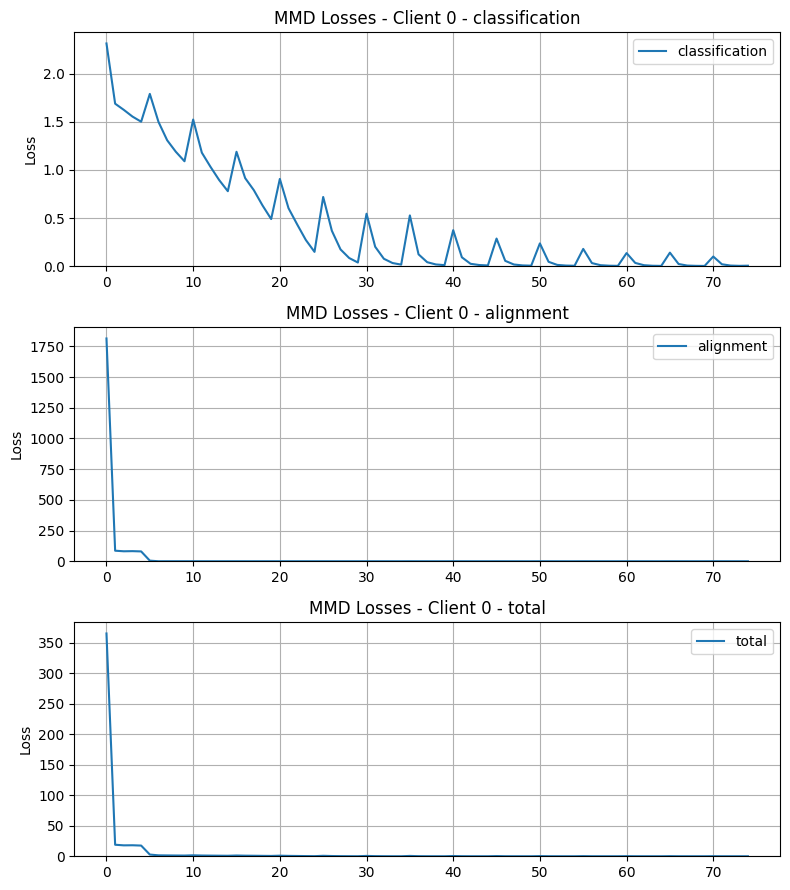

Saved plot to plots/MMD Losses_Client_1_alpha_0.5.png


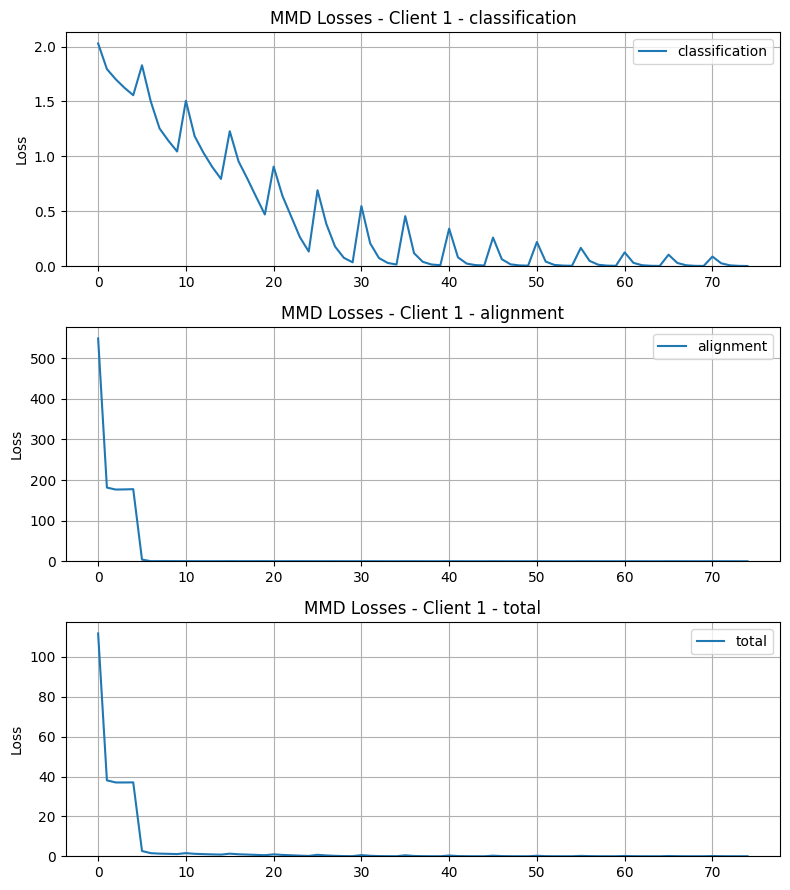

Saved plot to plots/MMD Losses_Client_2_alpha_0.5.png


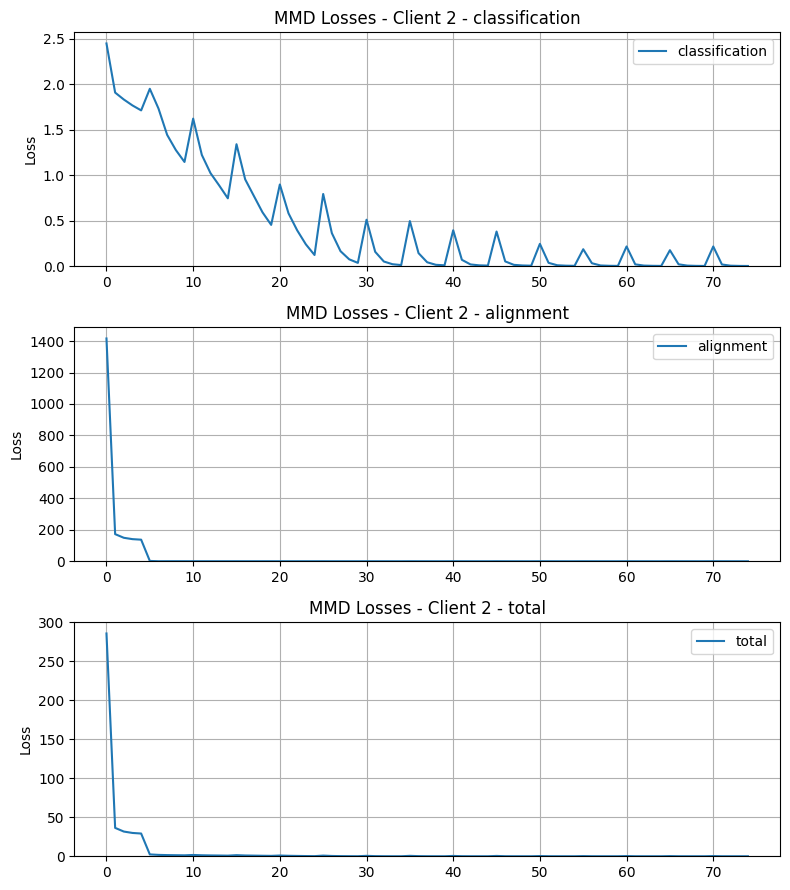

Saved plot to plots/MMD Losses_Client_3_alpha_0.5.png


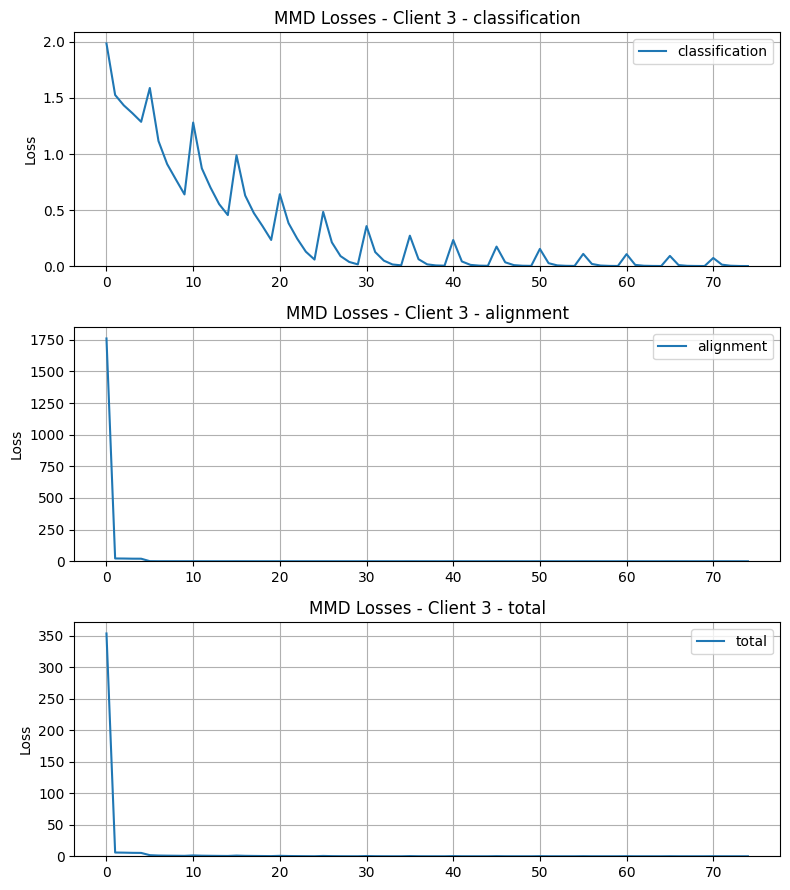

Saved plot to plots/MMD Losses_Client_4_alpha_0.5.png


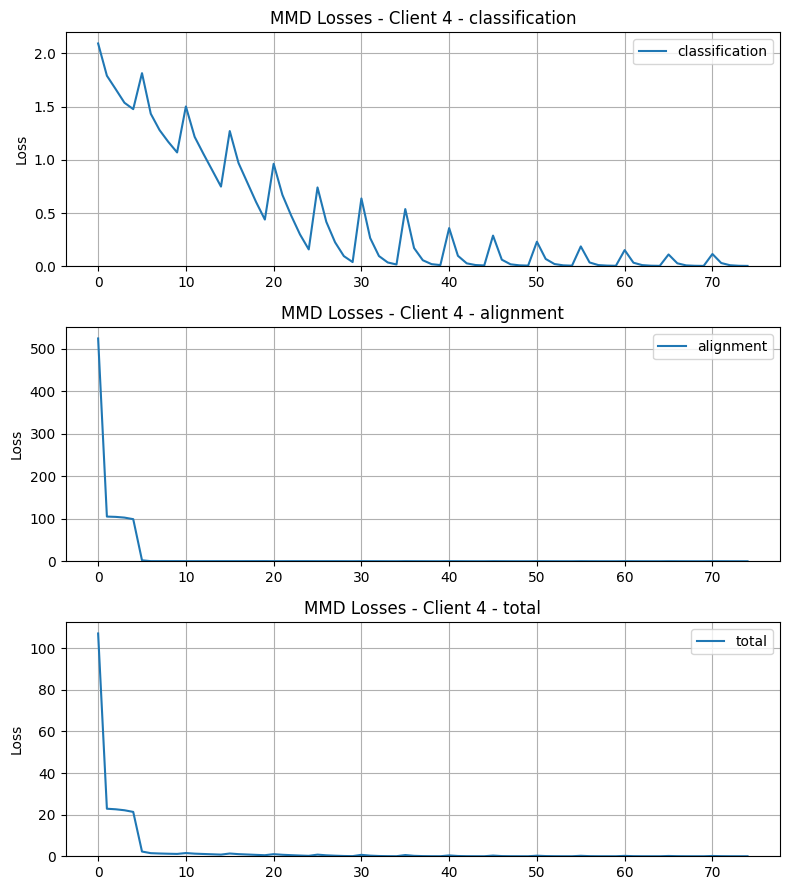

Plotting KL losses...
Saved plot to plots/KL Losses_Client_0_alpha_0.5.png


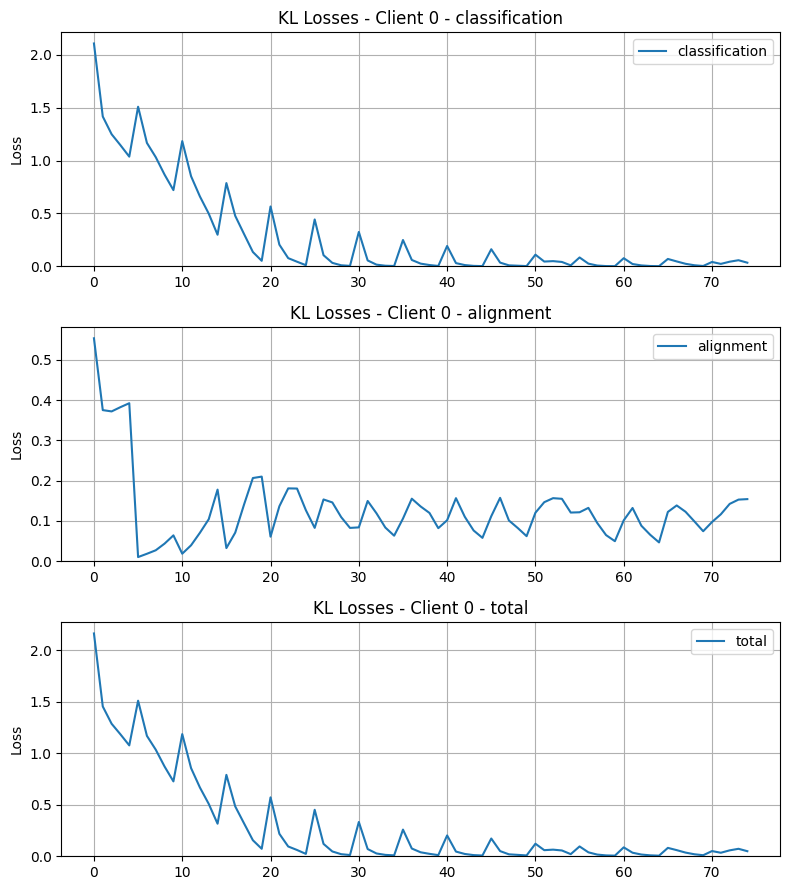

Saved plot to plots/KL Losses_Client_1_alpha_0.5.png


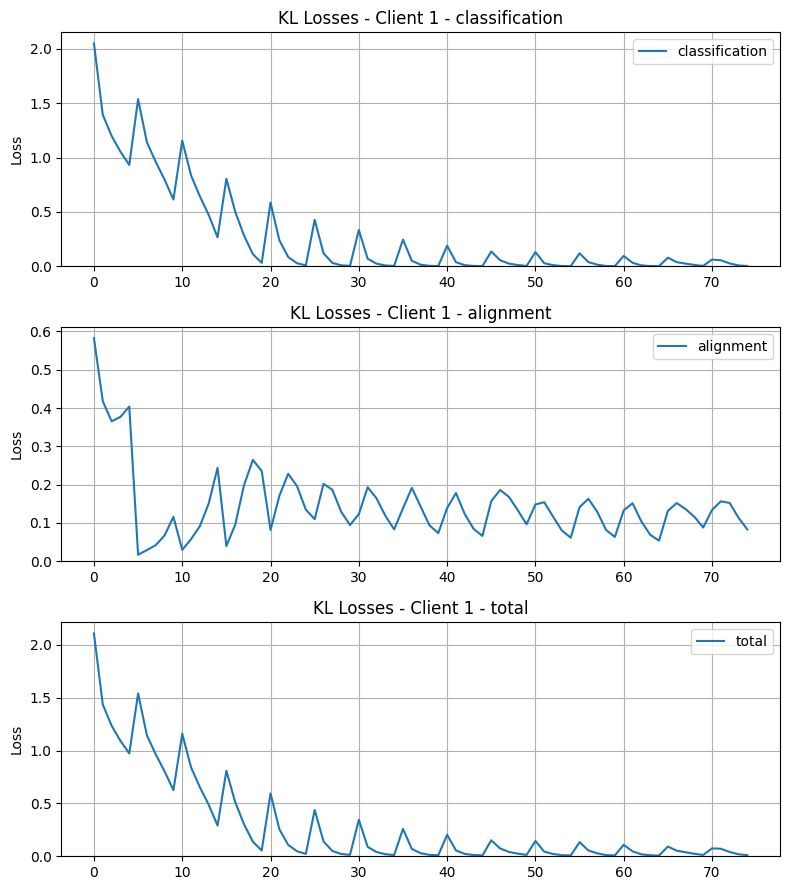

Saved plot to plots/KL Losses_Client_2_alpha_0.5.png


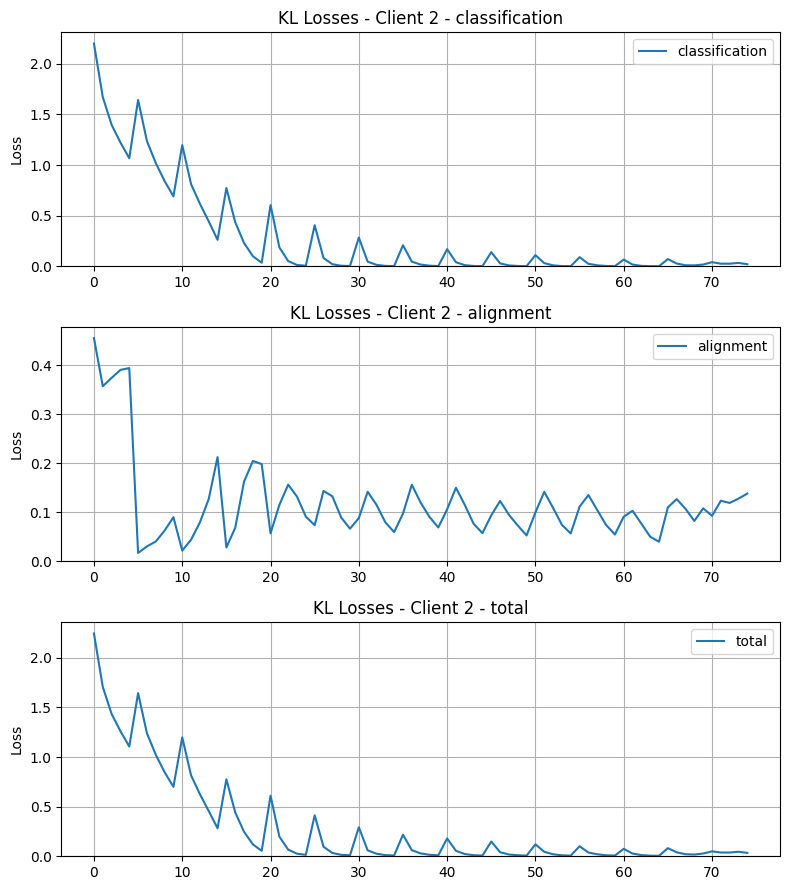

Saved plot to plots/KL Losses_Client_3_alpha_0.5.png


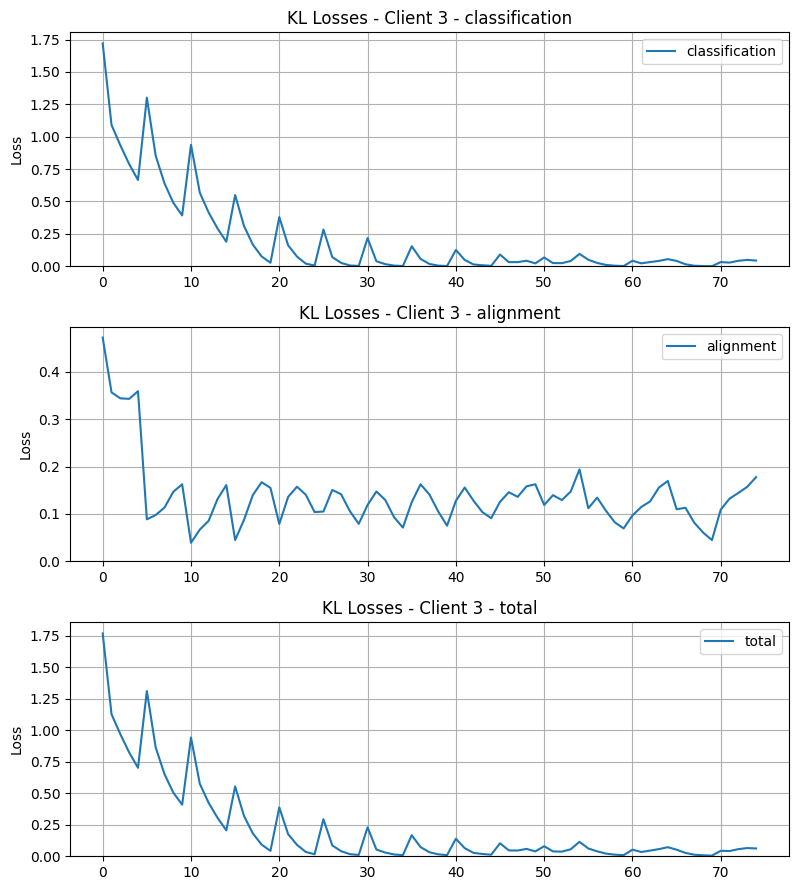

Saved plot to plots/KL Losses_Client_4_alpha_0.5.png


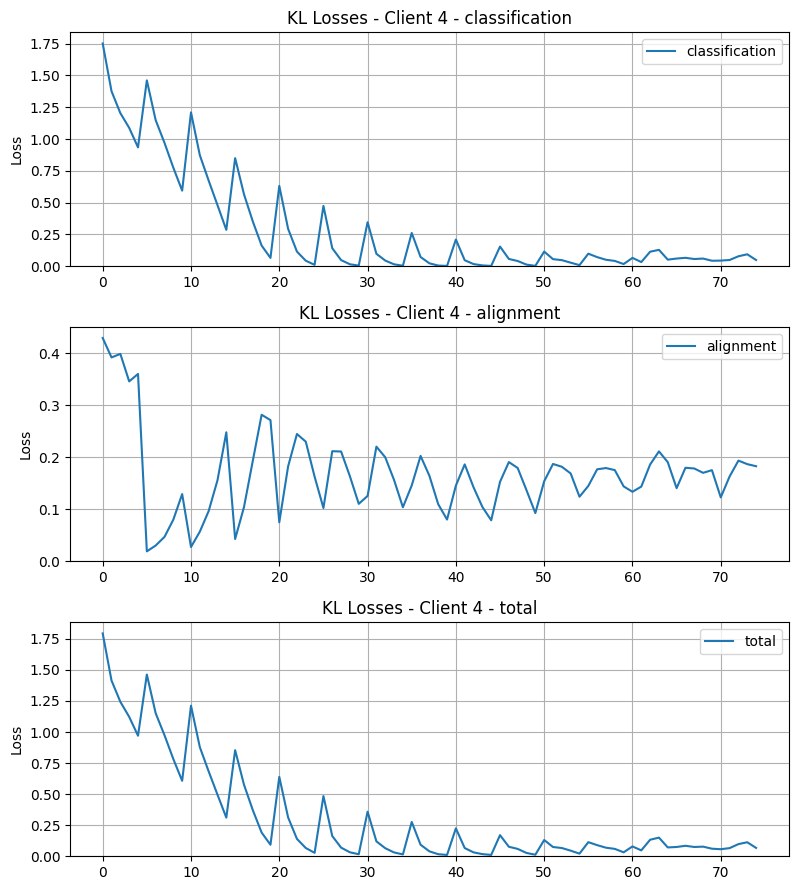

Plotting FedAvg losses...
Plotting MMD losses...
Saved plot to plots/MMD Losses_Client_0_alpha_2.png


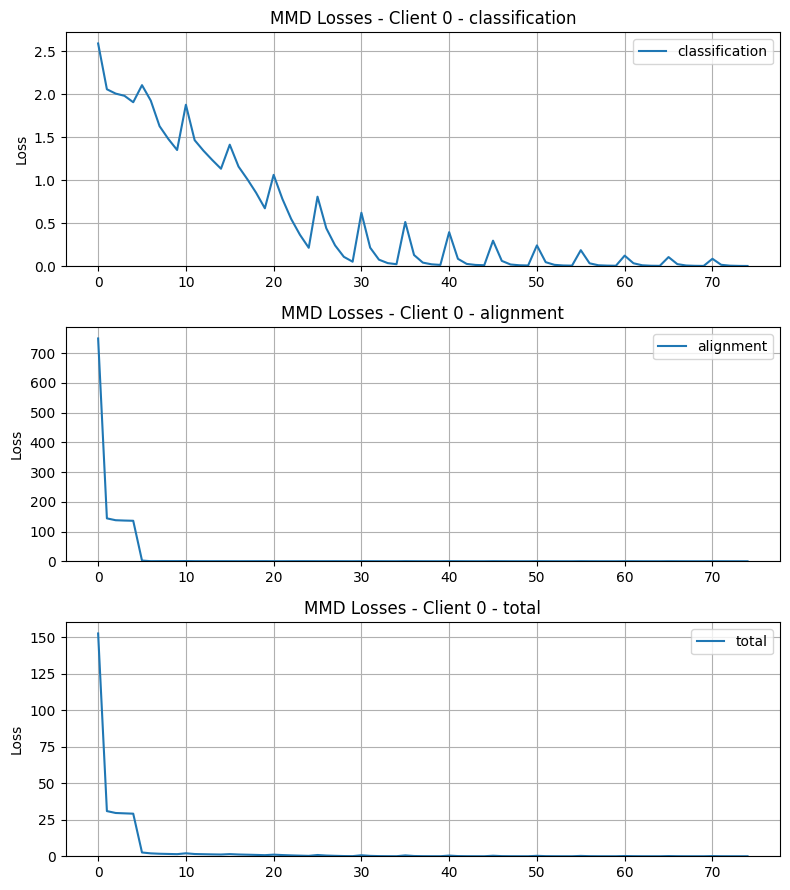

Saved plot to plots/MMD Losses_Client_1_alpha_2.png


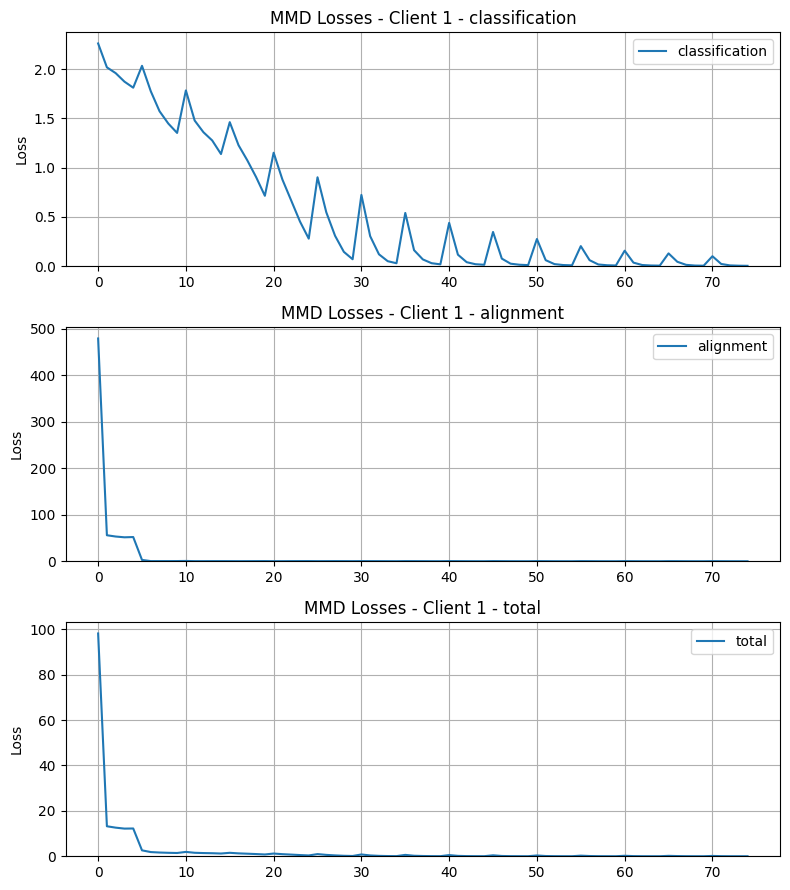

Saved plot to plots/MMD Losses_Client_2_alpha_2.png


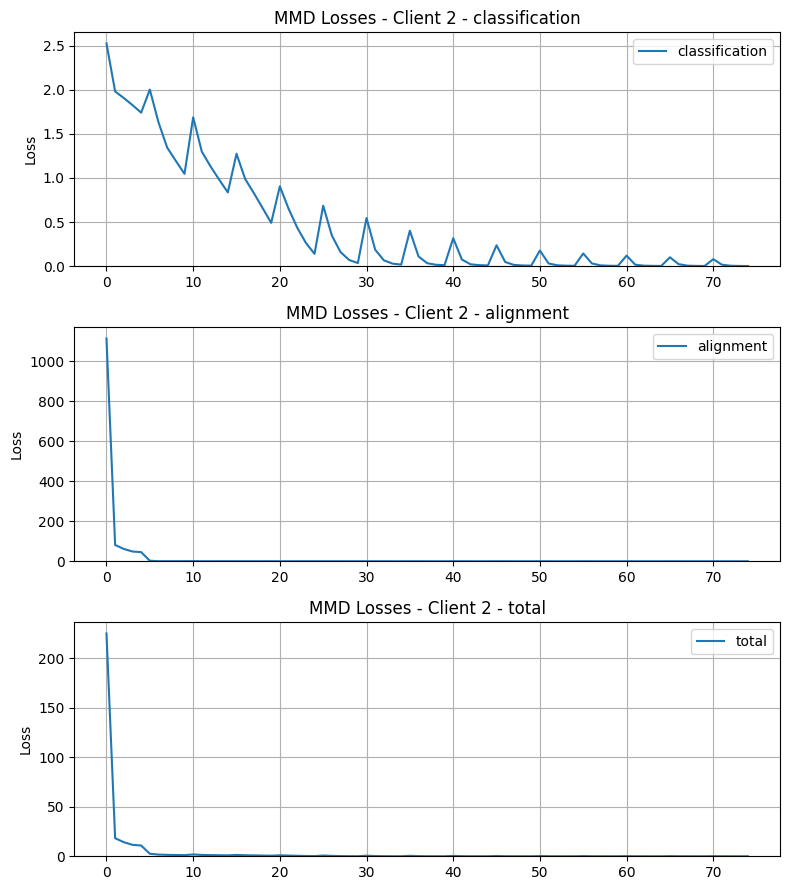

Saved plot to plots/MMD Losses_Client_3_alpha_2.png


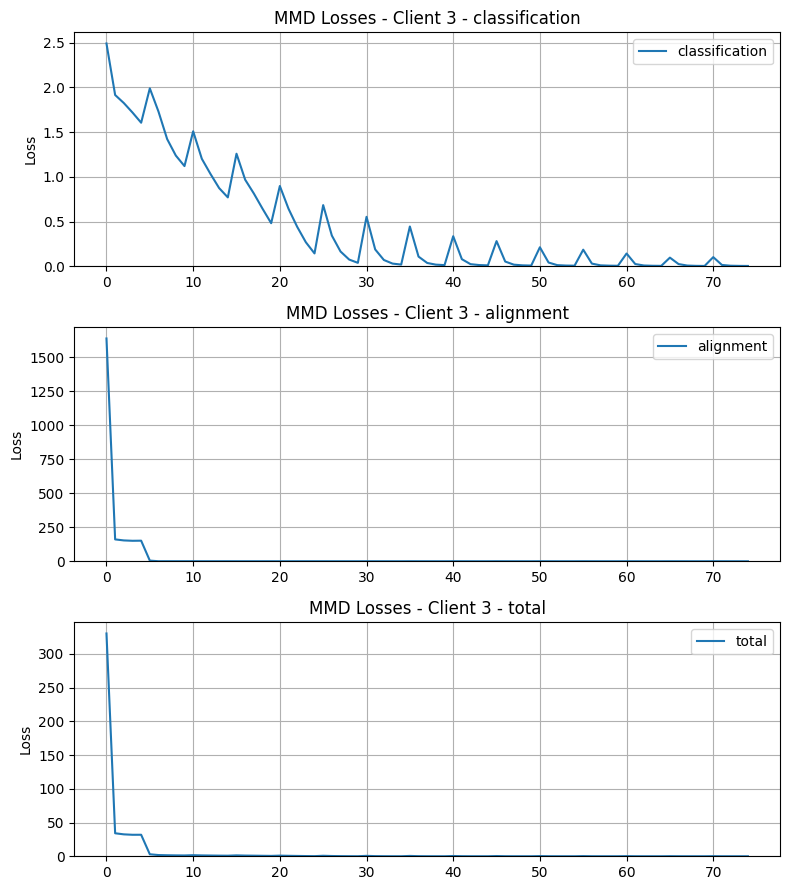

Saved plot to plots/MMD Losses_Client_4_alpha_2.png


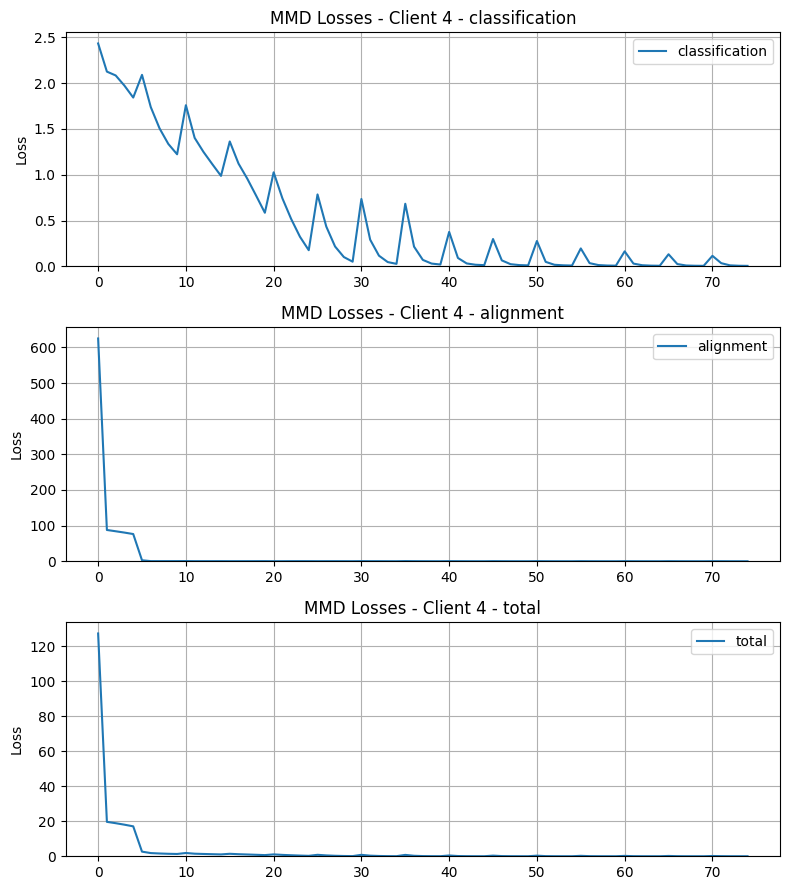

Plotting KL losses...
Saved plot to plots/KL Losses_Client_0_alpha_2.png


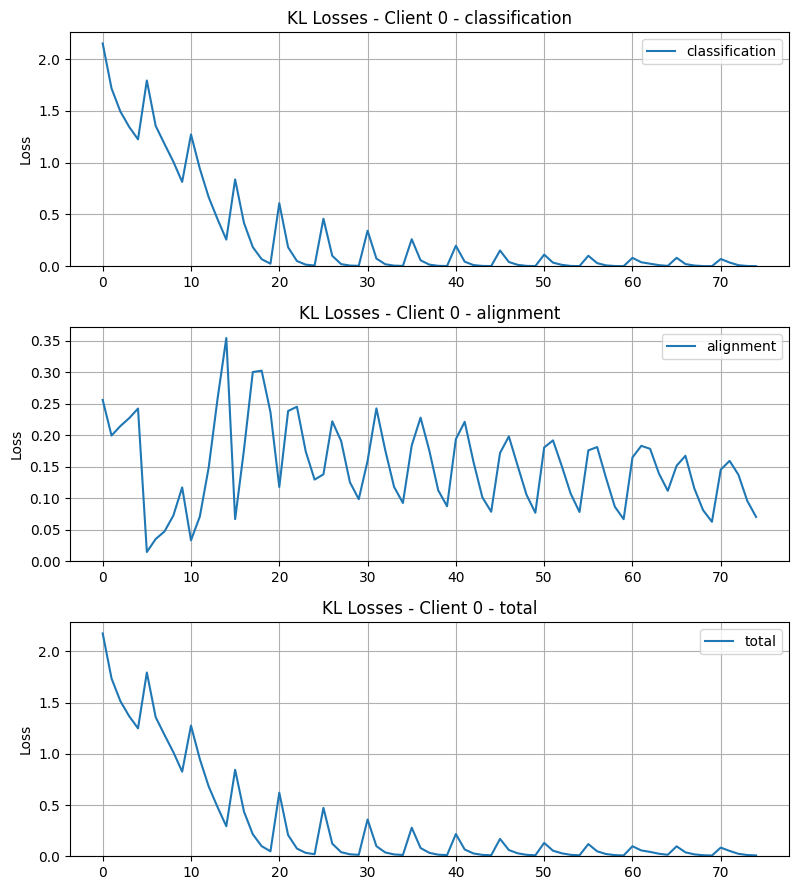

Saved plot to plots/KL Losses_Client_1_alpha_2.png


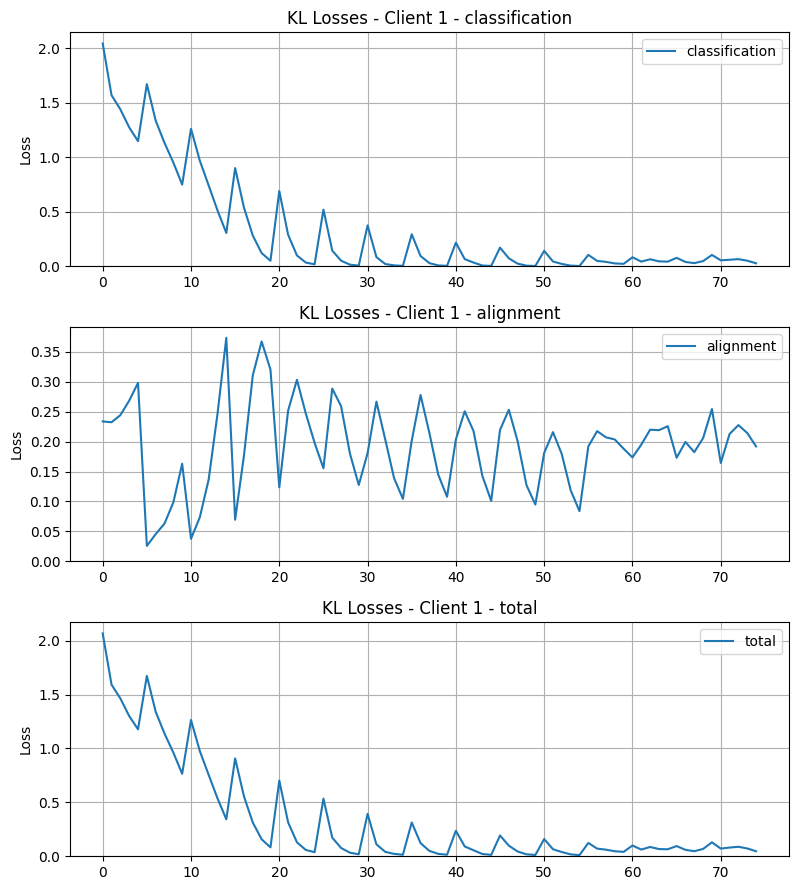

Saved plot to plots/KL Losses_Client_2_alpha_2.png


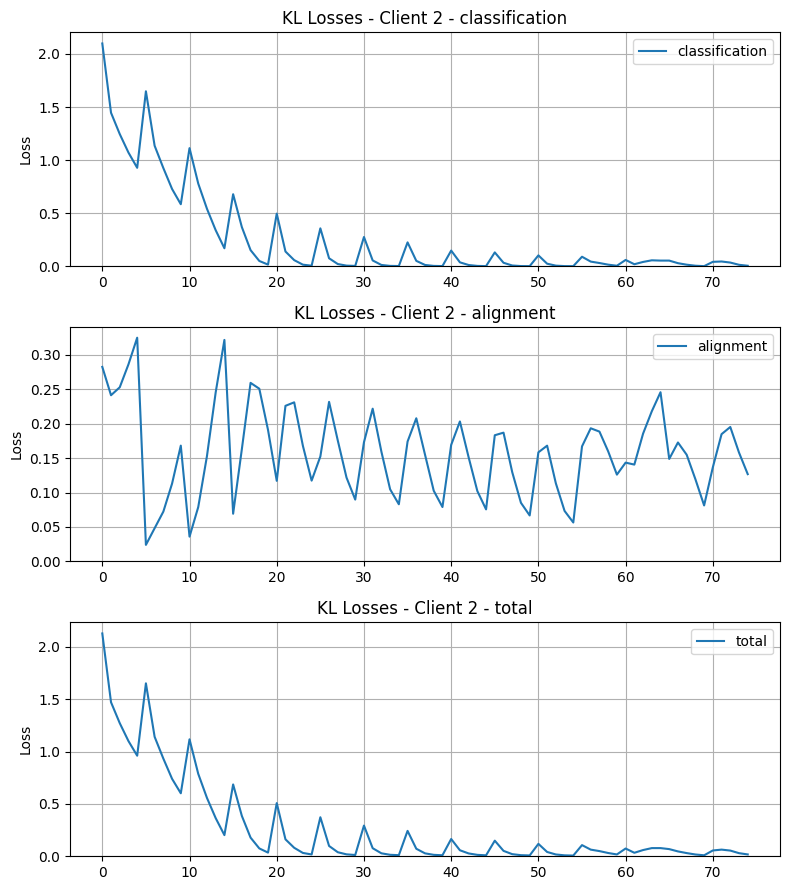

Saved plot to plots/KL Losses_Client_3_alpha_2.png


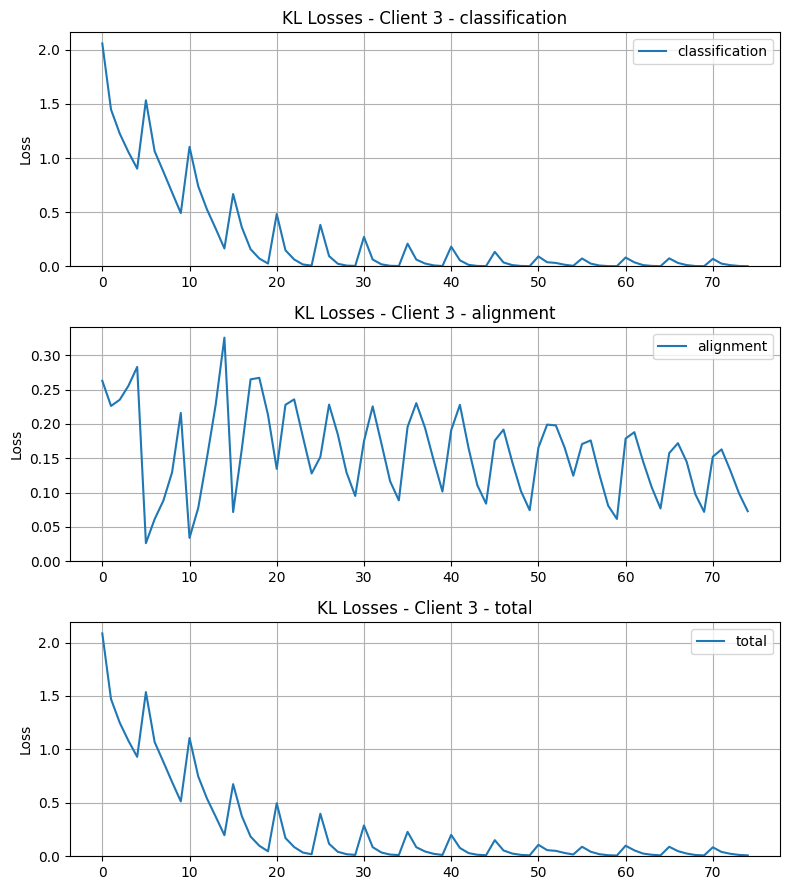

Saved plot to plots/KL Losses_Client_4_alpha_2.png


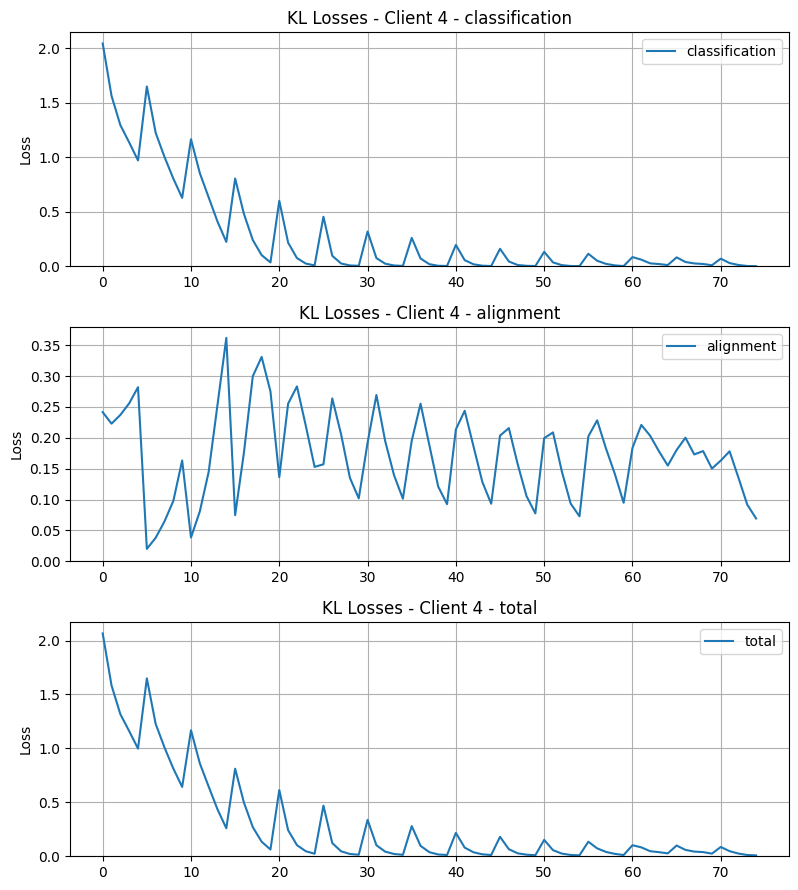

In [49]:
    
import matplotlib.pyplot as plt


def plot_losses(client_losses, title, alpha, save_dir="plots"):
    import os
    os.makedirs(save_dir, exist_ok=True)  # Ensure the save directory exists

    for client_id, losses in client_losses.items():
        # Number of subplots is the number of unique loss types
        loss_types = [loss_type for loss_type in losses.keys() if losses[loss_type] is not None]
        num_loss_types = len(loss_types)
        
        # Create subplots with smaller size
        fig, axes = plt.subplots(num_loss_types, 1, figsize=(8, 3 * num_loss_types))
        
        # If only one subplot, axes is not an array, so we convert it to an array for consistency
        if num_loss_types == 1:
            axes = [axes]
        
        for i, loss_type in enumerate(loss_types):
            loss_values = losses[loss_type]
            axes[i].plot(loss_values, label=loss_type)
            axes[i].set_title(f"{title} - Client {client_id} - {loss_type}")
            axes[i].set_ylabel("Loss")
            axes[i].grid()
            axes[i].legend()
            axes[i].set_ylim(bottom=0)  # Set the y-axis to start from 0
        
        # Adjust layout to avoid overlap
        plt.tight_layout()
        
        # Save the figure to the specified directory
        filename = os.path.join(save_dir, f"{title}_Client_{client_id}_alpha_{alpha}.png")
        plt.savefig(filename)
        print(f"Saved plot to {filename}")
        
        # Display the plot
        plt.show()
        
        # Close the figure to free up memory
        plt.close(fig)

from pprint import pprint
# pprint(losses_per_alpha)
for alpha in dirichlet_alphas:
    print("Plotting FedAvg losses...")
    # FedAvg_client_losses = losses_per_alpha[alpha]['FedAvg']
    # plot_losses(FedAvg_client_losses, "FedAvg Losses")
    
    print("Plotting MMD losses...")
    MMD_client_losses = losses_per_alpha[alpha]['MMD']
    plot_losses(MMD_client_losses, "MMD Losses", alpha)
    
    print("Plotting KL losses...")
    KL_client_losses = losses_per_alpha[alpha]['KL']
    # pprint(KL_client_losses)
    plot_losses(KL_client_losses, "KL Losses", alpha)



In [50]:
# accuracies_per_alpha = [([0.0916, 0.4061, 0.6492, 0.7035, 0.7184, 0.7309, 0.7355, 0.7382, 0.7395, 0.7381, 0.743, 0.7425, 0.7423, 0.7411, 0.7393], [0.1631, 0.1071, 0.4643, 0.6478, 0.6972, 0.7296, 0.7359, 0.7409, 0.7423, 0.7428, 0.7439, 0.7446, 0.7441, 0.7446, 0.7454], [0.0997, 0.2894, 0.6679, 0.7306, 0.7457, 0.7551, 0.7589, 0.7629, 0.7636, 0.7651, 0.7665, 0.7669, 0.7599, 0.7684, 0.7615]), ([0.097, 0.2158, 0.5691, 0.658, 0.6786, 0.6971, 0.6988, 0.7126, 0.7002, 0.7122, 0.7125, 0.7186, 0.7159, 0.7129, 0.7164], [0.1149, 0.0952, 0.3641, 0.5355, 0.6384, 0.6692, 0.6846, 0.6928, 0.6976, 0.704, 0.7044, 0.7045, 0.707, 0.7094, 0.7089], [0.0997, 0.3253, 0.6062, 0.6796, 0.6963, 0.7089, 0.7161, 0.7217, 0.7235, 0.7259, 0.7301, 0.7261, 0.7213, 0.7284, 0.7314])]
# dirichlet_alphas = [2, 0.5]

print(accuracies_per_alpha)

[([], [0.1598, 0.0952, 0.1981, 0.5015, 0.6316, 0.6764, 0.6935, 0.703, 0.706, 0.7142, 0.715, 0.7165, 0.7203, 0.7202, 0.7183], [0.0951, 0.2014, 0.5489, 0.6652, 0.7069, 0.7245, 0.7307, 0.7361, 0.7379, 0.7443, 0.7397, 0.7494, 0.745, 0.7466, 0.7463]), ([], [0.1066, 0.1261, 0.1629, 0.5433, 0.6274, 0.6499, 0.6633, 0.6695, 0.6742, 0.6764, 0.6777, 0.6804, 0.6823, 0.6818, 0.6824], [0.0997, 0.2765, 0.6619, 0.7208, 0.74, 0.7455, 0.7526, 0.7538, 0.7578, 0.7571, 0.7543, 0.7576, 0.7534, 0.7523, 0.755])]


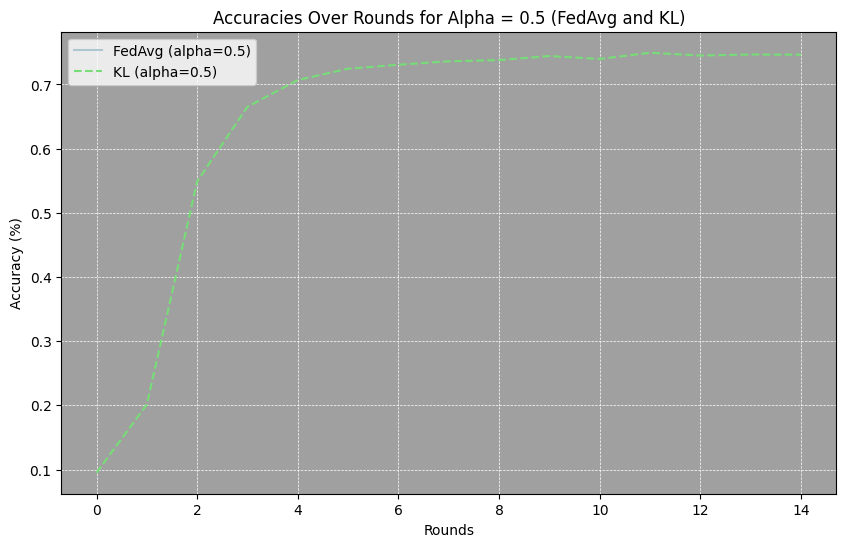

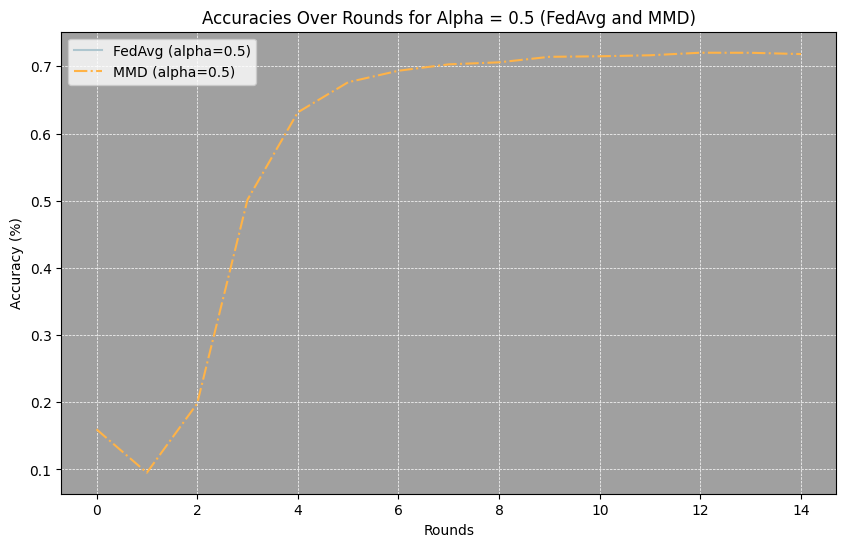

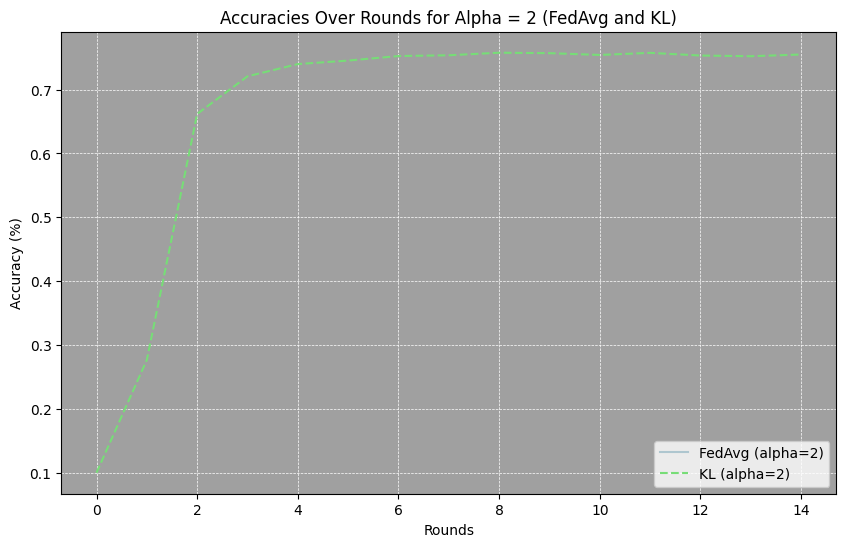

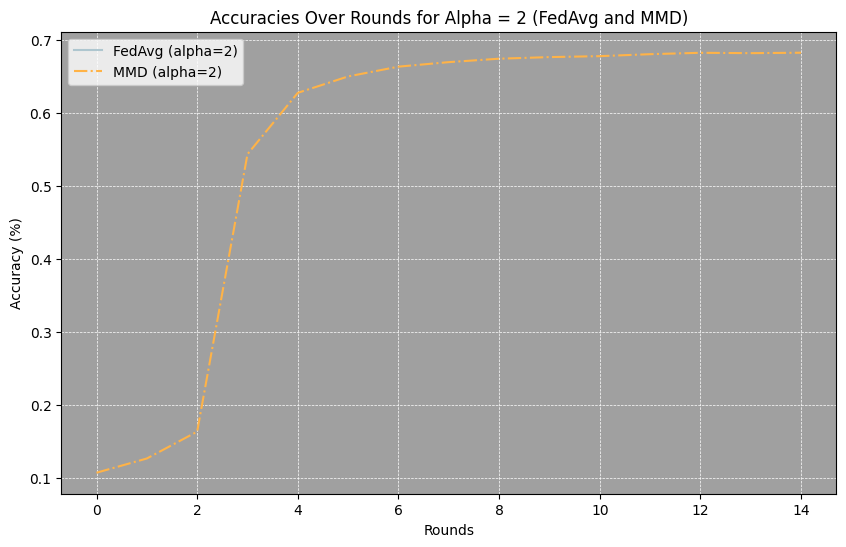

In [51]:
import matplotlib.pyplot as plt

def plot_accuracies(dirichlet_alphas, accuracies_per_alpha, label1="FedAvg", label2="MMD", label3="KL"):
    pastel_colors = {
        label1: "#AEC6CF",  # Light pastel blue
        label2: "#FFB347",  # Light pastel orange
        label3: "#77DD77",  # Light pastel green
    }

    for i, alpha in enumerate(dirichlet_alphas):
        # Extract accuracy lists for MMD, KL, and FedAvg
        FedAvg_accuracies, MMD_accuracies, KL_accuracies = accuracies_per_alpha[i]

        # Plot for FedAvg and KL
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.set_facecolor("#A0A0A0")  # Light grey background
        ax.plot(FedAvg_accuracies, label=f"{label1} (alpha={alpha})", linestyle='-', color=pastel_colors[label1])
        ax.plot(KL_accuracies, label=f"{label3} (alpha={alpha})", linestyle="--", color=pastel_colors[label3])
        ax.set_title(f"Accuracies Over Rounds for Alpha = {alpha} (FedAvg and KL)")
        ax.set_xlabel("Rounds")
        ax.set_ylabel("Accuracy (%)")
        ax.legend()
        ax.grid(True, color="white", linestyle="--", linewidth=0.5)
        plt.show()

        # Plot for FedAvg and MMD
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.set_facecolor("#A0A0A0")  # Light grey background
        ax.plot(FedAvg_accuracies, label=f"{label1} (alpha={alpha})", linestyle='-', color=pastel_colors[label1])
        ax.plot(MMD_accuracies, label=f"{label2} (alpha={alpha})", linestyle="-.", color=pastel_colors[label2])
        ax.set_title(f"Accuracies Over Rounds for Alpha = {alpha} (FedAvg and MMD)")
        ax.set_xlabel("Rounds")
        ax.set_ylabel("Accuracy (%)")
        ax.legend()
        ax.grid(True, color="white", linestyle="--", linewidth=0.5)
        plt.show()


plot_accuracies(dirichlet_alphas, accuracies_per_alpha)
